# Análise de Sentimentos em Discursos de Conflitos Internacionais

Mais explicações sobre o projeto, podem ser acompanhadas a partir do vídeo:
- [Análise de Sentimentos em Discursos de Conflitos Internacionais](https://youtu.be/qTNbjE-_Yc4)

## Introdução

O presente projeto tem como objetivo central a análise de discursos e a previsão de sua polaridade, categorizando-os como `war_support`, `war_opposite` ou `neutral`, e também a geração de uma predição se o comentário é sobre o conflito Israel x Palestina ou Russia x Ucrania. 

A fonte de dados para esta investigação foram dois conjuntos disponíveis na plataforma Kaggle, sendo eles:

- [Israel Palestine War Sentiment Analysis](https://www.kaggle.com/code/shamsheerrahiman/israel-palestine-war-sentiment-analysis/)
- [Ukraine Russia War Reddit Data](https://www.kaggle.com/datasets/diyacharya/ukraine-russia-war-reddit-data)


Esses conjuntos de dados foram escolhidos devido à riqueza de informações relacionadas aos sentimentos expressos nos comentários em ambientes online durante períodos sensíveis de conflitos geopolíticos. 

O projeto visa empregar técnicas avançadas de processamento de linguagem natural e aprendizado profundo, especificamente utilizando um modelo LSTM (Long Short-Term Memory), para realizar análises preditivas e extrair insights significativos a partir desses discursos. 

O contexto geopolítico desses conflitos, aliado à diversidade linguística e à polarização de opiniões, torna essa análise de extrema relevância para compreender as nuances dos sentimentos expressos durante eventos de grande impacto global.

In [1]:
!pip install -q tensorflow
!pip install -q matplotlib 
!pip install -q seaborn

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion ca

In [2]:
import re
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import nltk
from nltk import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-14 02:54:31.342593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 02:54:31.342619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 02:54:31.343396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 02:54:31.348374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

True

## Metodologia

### Preparação do Dataframe

A etapa de preparação de dados visa consolidar informações relacionadas aos conflitos entre Rússia e Ucrânia, assim como Israel e Palestina. Os arquivos 'ukr_rus_reddit_comments.csv' e 'isr_pse_reddit_comments.csv' são utilizados para obter comentários relacionados a Rússia x Ucrânia e Israel x Palestina, respectivamente.

O processo essencial resulta na criação do DataFrame `conflict_war_df`, uma união coerente dos DataFrames rus_ukr_df e isr_pse_df. Essa consolidação é fundamental para análises subsequentes, fornecendo uma representação organizada e unificada dos dados cruciais para o projeto.

O DataFrame resultante, `conflict_war_df`, inclui as colunas `post_id`, `comments`, e `conflict`, estabelecendo a base unificada para análises posteriores.

In [3]:
file_path = 'ukr_rus_reddit_comments.csv'
rus_ukr_df = pd.read_csv(file_path)

rus_ukr_df['conflict'] = 'russia_ukraine'
rus_ukr_df = rus_ukr_df[['post_id', 'comments', 'conflict']]

rus_ukr_df.head()

,post_id,comments,conflict
0,vlvgj4,"Hello /u/hjgbuijhgh,\n\nThis community is focu...",russia_ukraine
1,vlvgj4,uhm thats quite the increase. \n\n\nI also he...,russia_ukraine
2,vlvgj4,Poland also announced that they plan to double...,russia_ukraine
3,vlvgj4,"Remember, NATO knows more than we’re being tol...",russia_ukraine
4,vlvgj4,"Well done, Putin. Top 2022 salesman of NATO. \...",russia_ukraine


In [4]:
file_path = 'isr_pse_reddit_comments.csv'
isr_pse_df = pd.read_csv(file_path)

isr_pse_df = isr_pse_df.rename(columns={'comment_id': 'post_id', 'self_text': 'comments'})
isr_pse_df['conflict'] = 'israel_palestine'
isr_pse_df = isr_pse_df[['post_id', 'comments', 'conflict']]

isr_pse_df = isr_pse_df.sample(n=100000)
isr_pse_df.head()

,post_id,comments,conflict
204263,k5ds4d6,"Hamas is close with Iran, who is close with bo...",israel_palestine
97850,k67mfob,A single AEGIS ship is pretty much the best ai...,israel_palestine
195906,k5fqjs9,I don't think many people look back through hi...,israel_palestine
201531,k5e74r0,I don’t get free land in Europe because ancien...,israel_palestine
273758,k4xk4u2,To download the video you can use one of the f...,israel_palestine


In [5]:
conflict_war_df = pd.concat([isr_pse_df, rus_ukr_df]).sort_index(level=1)
conflict_war_df.head()

,post_id,comments,conflict
0,vlvgj4,"Hello /u/hjgbuijhgh,\n\nThis community is focu...",russia_ukraine
1,vlvgj4,uhm thats quite the increase. \n\n\nI also he...,russia_ukraine
1,k70vk4r,Translation:\n\nAmen. Kill jews and continue g...,israel_palestine
2,k70vhew,Friendly fact reminder: Israel has been steali...,israel_palestine
2,vlvgj4,Poland also announced that they plan to double...,russia_ukraine


### Pré-Processamento dos Comentários

Antes da análise de sentimentos, é essencial pré-processar os textos dos comentários com as seguintes etapas:

1. **Remoção de Pontuações e Caracteres Especiais:** Eliminação de elementos não alfanuméricos.
2. **Tokenização e Conversão para Minúsculas:** Divisão dos comentários em palavras e conversão para minúsculas.
3. **Remoção de Stopwords:** Exclusão de palavras comuns sem significado contextual.
4. **Lemmatização:** Redução de palavras à sua forma base.
5. **Reconstrução do Texto Pré-Processado:** Unificação dos tokens para formar o texto final.

Essas etapas garantem que os comentários estejam prontos para análise, facilitando a eficácia do modelo de aprendizado subsequente. O DataFrame resultante, `conflict_war_df`, reflete os comentários após o pré-processamento, preparando-os para análises mais aprofundadas.

In [6]:
# Inicializar o lematizador
lemmatizer = WordNetLemmatizer()

# Função de pré-processamento
def preprocess_text(text):
    # Remover pontuações e caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenização e conversão para minúsculas
    tokens = text.lower().split()
    
    # Remoção de stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatização
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Reconstruir o texto pré-processado
    processed_text = ' '.join(tokens)
    
    return processed_text

# Aplicar a função à coluna 'comments'
tqdm.pandas(desc='Pré-Processando os comentários')
conflict_war_df['comments'] = conflict_war_df['comments'].progress_apply(preprocess_text)

conflict_war_df.head()

Pré-Processando os comentários:   0%|          | 0/116707 [00:00<?, ?it/s]

,post_id,comments,conflict
0,vlvgj4,hello uhjgbuijhgh community focused important ...,russia_ukraine
1,vlvgj4,uhm thats quite increase also heared recently ...,russia_ukraine
1,k70vk4r,translation amen kill jew continue gazan oppre...,israel_palestine
2,k70vhew,friendly fact reminder israel stealing palesti...,israel_palestine
2,vlvgj4,poland also announced plan double armed force ...,russia_ukraine


### Análise de Sentimento

Utilizaremos a biblioteca NLTK para realizar a análise de sentimento nos comentários. Os comentários serão classificados como favoráveis à guerra, contrários à guerra ou neutros com base em escores de sentimento. O processo segue estas etapas:

1. **Criação do Analisador de Sentimentos:**
   - `sia = SentimentIntensityAnalyzer()`: Inicializa o analisador de sentimentos, uma ferramenta do NLTK.

2. **Função de Classificação de Sentimento:**
   - Define uma função `classify_sentiment(comment)` que atribui uma categoria ('war_support', 'war_opposite', ou 'neutral') com base no escore de sentimento composto.

3. **Aplicação da Função aos Comentários:**
   - `tqdm.pandas(desc='Classificando sentimentos')`: Utiliza a barra de progresso para acompanhar a aplicação da função.
   - `conflict_war_df['sentiment'] = tqdm(conflict_war_df['comments'].progress_apply(classify_sentiment))`: Aplica a função aos comentários, atribuindo a classificação de sentimentos à nova coluna 'sentiment'.

4. **Exibição do DataFrame Resultante:**
   - `conflict_war_df.head()`: Apresenta as primeiras linhas do DataFrame resultante, agora incluindo a classificação de sentimentos na coluna 'sentiment'.

Essas etapas oferecem uma categorização eficaz dos comentários em 'war_support', 'war_opposite' ou 'neutral', baseada nos escores de sentimento calculados. O DataFrame resultante, `conflict_war_df`, reflete a análise de sentimentos aplicada aos discursos sobre os conflitos, fornecendo insights sobre as posições expressas.

In [7]:
sia = SentimentIntensityAnalyzer()

# Função para classificar o sentimento
def classify_sentiment(comment):
    sentiment_score = sia.polarity_scores(comment)['compound']
    
    if sentiment_score > 0.05:
        return 'war_support'
    elif sentiment_score < -0.05:
        return 'war_opposite'
    else:
        return 'neutral'

# Aplicar a função à coluna 'comments'
tqdm.pandas(desc='Classificando sentimentos')
conflict_war_df['sentiment'] = conflict_war_df['comments'].progress_apply(classify_sentiment)

conflict_war_df.head()

Classificando sentimentos:   0%|          | 0/116707 [00:00<?, ?it/s]

  0%|          | 0/116707 [00:00<?, ?it/s]

,post_id,comments,conflict,sentiment
0,vlvgj4,hello uhjgbuijhgh community focused important ...,russia_ukraine,war_support
1,vlvgj4,uhm thats quite increase also heared recently ...,russia_ukraine,neutral
1,k70vk4r,translation amen kill jew continue gazan oppre...,israel_palestine,war_opposite
2,k70vhew,friendly fact reminder israel stealing palesti...,israel_palestine,war_opposite
2,vlvgj4,poland also announced plan double armed force ...,russia_ukraine,war_support


### Preparação dos Dados para o Modelo

Nesta etapa, realizamos operações essenciais:

- **Codificação das Classes:** Utilização do `LabelEncoder` para converter classes de conflito em valores numéricos.
- **Divisão em Treino e Teste:** Separação do conjunto de dados para treino e teste.
- **Tokenização:** Uso do `Tokenizer` para converter textos em sequências de tokens.
- **Sequências de Tokens:** Geração de sequências numéricas representando os textos.
- **Preenchimento das Sequências:** Padronização do comprimento das sequências para entrada no modelo.

Essas etapas preparam os dados para o treinamento, garantindo uma representação numérica adequada dos textos e a divisão apropriada entre conjuntos de treino e teste.

In [8]:
# Pré-processamento
le = LabelEncoder()
conflict_war_df['label'] = le.fit_transform(conflict_war_df['conflict'])

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(conflict_war_df['comments'], conflict_war_df['label'], test_size=0.2, random_state=42)

# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

# Preenchimento das sequências
X_train_padded = pad_sequences(X_train_seq, maxlen=50, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=50, padding='post')

### Treinamento do Modelo

Construiremos um modelo de aprendizado profundo utilizando uma camada de embedding seguida por uma camada bidirecional LSTM e uma camada densa para a classificação binária. O modelo será treinado com dados balanceados em termos de peso de classe. Nesta etapa, configuramos e treinamos o modelo com as seguintes operações principais:

- **Balanço de Pesos de Classe:**
  Calculamos os pesos das classes para lidar com desequilíbrios durante o treinamento.

- **Construção do Modelo:**
  Definimos um modelo sequencial com camada de embedding, LSTM bidirecional e camada densa para classificação binária, utilizando a função de ativação 'sigmoid' na camada de saída.
  
- **Treinamento do Modelo:**
   O modelo foi treinado com sucesso por 5 épocas, utilizando estratégia de parada antecipada para evitar overfitting. 
Essas etapas estabelecem a arquitetura do modelo e garantem uma abordagem equilibrada ao treinar com dados ponderados corretamente.

In [9]:
# Balanço de pesos de classe
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Construção do modelo
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=50))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2023-12-14 02:55:16.791629: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [10]:
# Treinamento do modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(
    X_train_padded,
    y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Epoch 1/5
2335/2335 [==============================] - 125s 53ms/step - loss: 0.3823 - accuracy: 0.7858 - val_loss: 0.3484 - val_accuracy: 0.8261
Epoch 2/5
2335/2335 [==============================] - 119s 51ms/step - loss: 0.2572 - accuracy: 0.8791 - val_loss: 0.3100 - val_accuracy: 0.8505
Epoch 3/5
2335/2335 [==============================] - 117s 50ms/step - loss: 0.1887 - accuracy: 0.9141 - val_loss: 0.3398 - val_accuracy: 0.8563
Epoch 4/5
2335/2335 [==============================] - 117s 50ms/step - loss: 0.1426 - accuracy: 0.9320 - val_loss: 0.4034 - val_accuracy: 0.8346
Epoch 5/5
2335/2335 [==============================] - 117s 50ms/step - loss: 0.1091 - accuracy: 0.9460 - val_loss: 0.4646 - val_accuracy: 0.8398


In [11]:
# Avaliação do modelo
y_pred_probs = model.predict(X_test_padded)
y_pred = (y_pred_probs > 0.5).astype(int)

730/730 [==============================] - 4s 5ms/step


## Resultados

Após treinar o modelo, avaliaremos sua performance utilizando dados de teste, onde aplicamos métricas de avaliação para destacar os principais resultados:

- **Contagem de Sentimentos:**
   - Visualização de barra mostrando a distribuição de sentimentos ('war_support', 'war_opposite', 'neutral') nos comentários.
- **Distribuição de Sentimentos por Conflito:**
   - Gráfico de barras agrupado por conflito (israel_palestine e russia_ukraine).
   - Exibe a distribuição de sentimentos em cada contexto.
- **Métricas de Avaliação por Classe:**
   - Tabela e gráfico de barras com métricas de avaliação (precisão, recall, pontuação F1) para cada classe.
   - Oferece insights sobre o desempenho do modelo em diferentes categorias.
- **Matriz de Confusão:**
   - Ilustra como as previsões do modelo correspondem às classes reais.
- **Curva ROC (Receiver Operating Characteristic) e AUC:**
   - Avaliação do desempenho em diferentes limiares de classificação.
- **Curva Precision-Recall:**
   - Destaca a precisão em relação à revocação em diversos pontos de corte.
   
Esses resultados proporcionam uma visão abrangente do desempenho do modelo e da distribuição de sentimentos nos dados analisados.

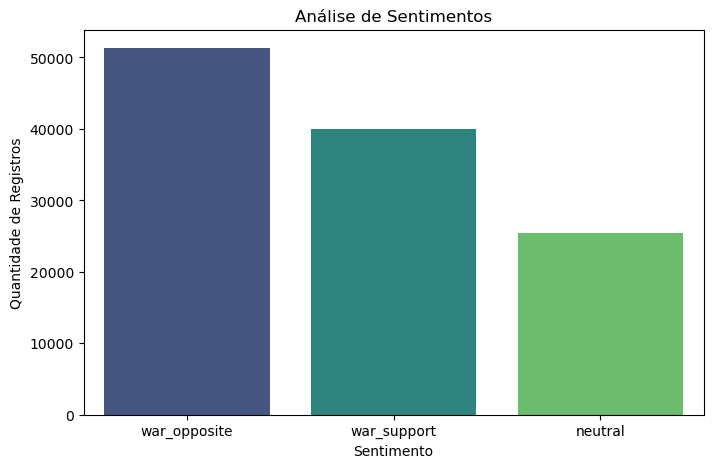

In [12]:
# Contagem de sentimentos
sentiment_counts = conflict_war_df['sentiment'].value_counts()

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Análise de Sentimentos')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade de Registros')
plt.show()

In [13]:
sentiment_counts

war_opposite    51340
war_support     40003
neutral         25364
Name: sentiment, dtype: int64

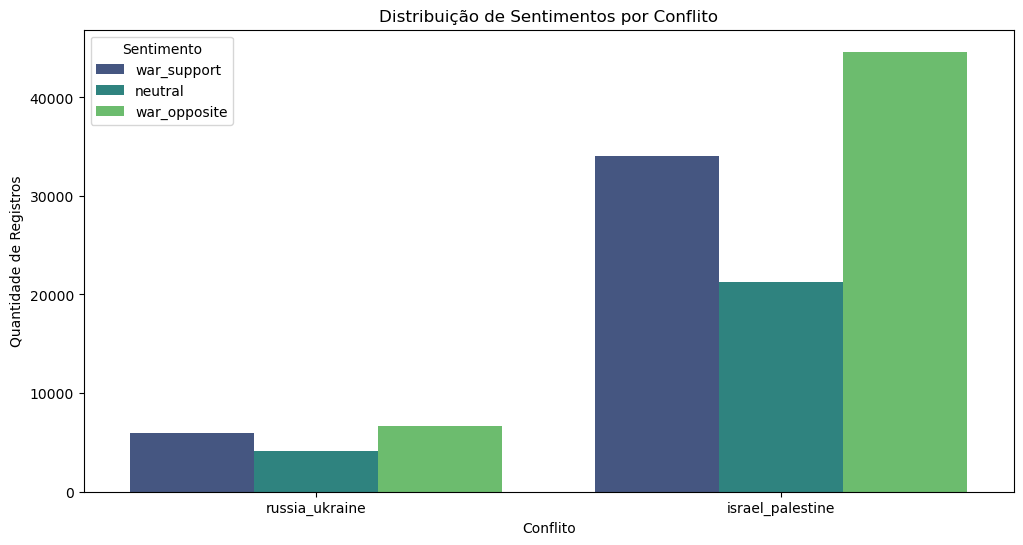

In [14]:
# Gráfico de barras de sentimentos por conflito
plt.figure(figsize=(12, 6))
sns.countplot(x='conflict', hue='sentiment', data=conflict_war_df, palette="viridis")
plt.title('Distribuição de Sentimentos por Conflito')
plt.xlabel('Conflito')
plt.ylabel('Quantidade de Registros')
plt.legend(title='Sentimento')
plt.show()

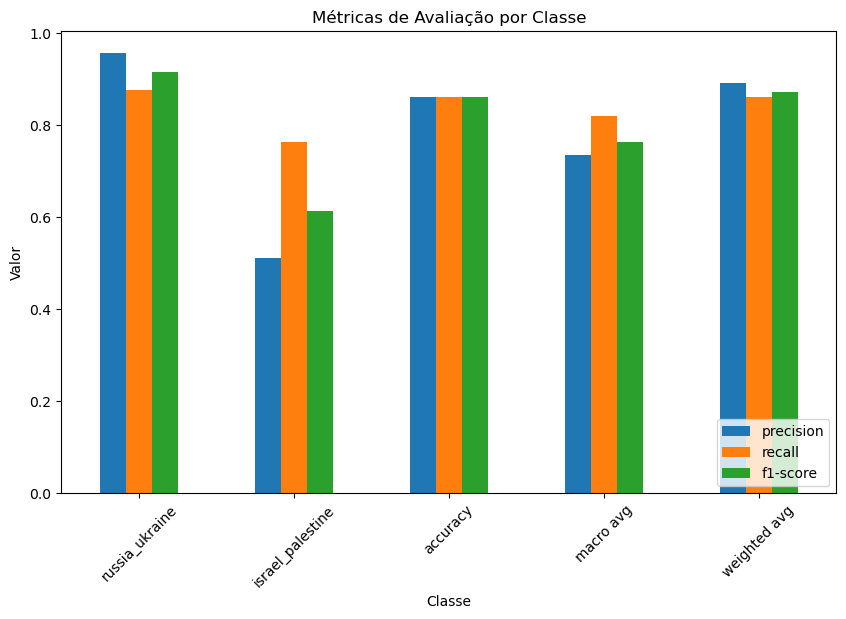

In [15]:
classification_rep = classification_report(y_test, y_pred, target_names=conflict_war_df['conflict'].unique(), output_dict=True)

classification_df = pd.DataFrame(classification_rep).transpose()

# Extrair as métricas relevantes
metrics_df = classification_df[['precision', 'recall', 'f1-score']]

# Plotar um gráfico de barras
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Métricas de Avaliação por Classe')
plt.ylabel('Valor')
plt.xlabel('Classe')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

In [23]:
classification_df

,precision,recall,f1-score,support
russia_ukraine,0.956066,0.876597,0.914608,19959.000000
israel_palestine,0.511503,0.762341,0.612226,3383.000000
accuracy,0.860038,0.860038,0.860038,0.860038
macro avg,0.733784,0.819469,0.763417,23342.000000
weighted avg,0.891634,0.860038,0.870783,23342.000000


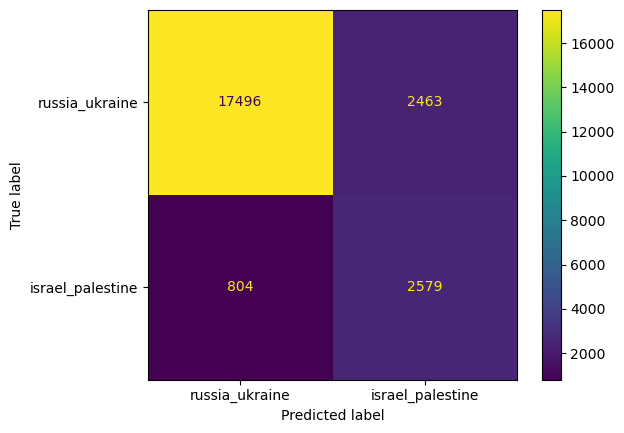

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=conflict_war_df['conflict'].unique()).plot()

In [18]:
conf_matrix

array([[17496,  2463],
       [  804,  2579]])

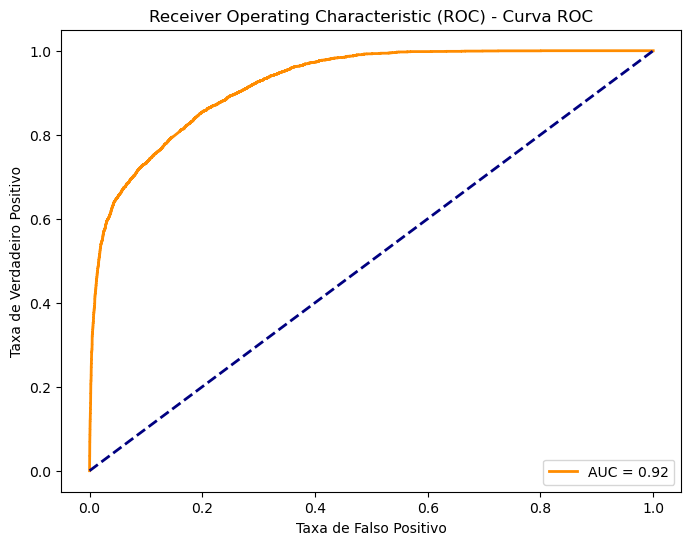

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Receiver Operating Characteristic (ROC) - Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [20]:
roc_auc

0.9224068814910353

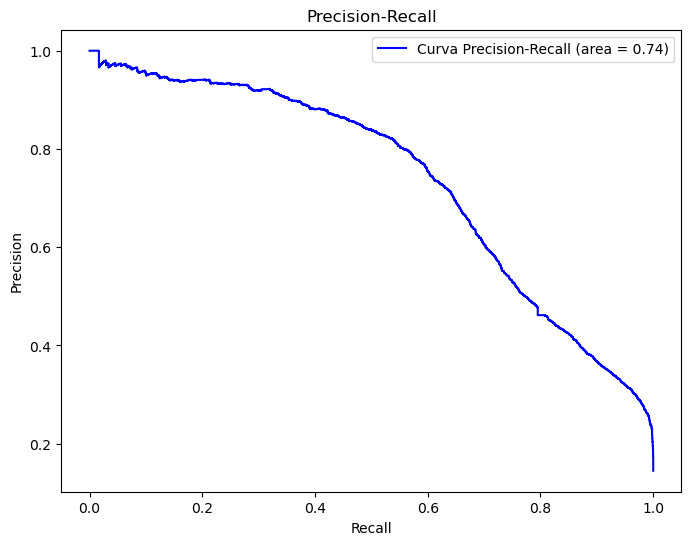

In [21]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
avg_precision = average_precision_score(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label='Curva Precision-Recall (area = {:.2f})'.format(avg_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc='upper right')
plt.show()

In [22]:
avg_precision

0.7373965674341182

In [25]:
conflict_war_df.drop('label', axis=1, inplace=True)
conflict_war_df.head()

,post_id,comments,conflict,sentiment,label
0,vlvgj4,hello uhjgbuijhgh community focused important ...,russia_ukraine,war_support,1
1,vlvgj4,uhm thats quite increase also heared recently ...,russia_ukraine,neutral,1
1,k70vk4r,translation amen kill jew continue gazan oppre...,israel_palestine,war_opposite,0
2,k70vhew,friendly fact reminder israel stealing palesti...,israel_palestine,war_opposite,0
2,vlvgj4,poland also announced plan double armed force ...,russia_ukraine,war_support,1


## Contribuições

Sobre o projeto, destaca-se a geração de um arquivo CSV, `conflict_war_df.csv`, consolidando todas as contribuições produzidas a partir dessa iniciativa. 
O arquivo abaixo, reflete o conteúdo do dataframe, incluindo informações cruciais como `post_id`, `comments`, `conflict`, e `sentiment`. Essa exportação facilita a posterior análise e compartilhamento dos resultados obtidos.

In [24]:
conflict_war_df.to_csv('conflict_war_df.csv', index=False)

## Conclusão e Considerações Finais

A implementação do modelo LSTM apresentou resultados promissores na análise de sentimentos em discursos relacionados aos conflitos Israel x Palestina e Russia x Ucrania. Observamos um progresso significativo ao longo das épocas de treinamento, com aumento na precisão e redução na perda. No entanto, a parada antecipada foi acionada na terceira época para evitar overfitting.

As métricas de avaliação por classe mostram que o modelo alcançou alta precisão (0.956 para russia_ukraine), mas um desempenho mais modesto em recall e pontuação F1 para a classe israel_palestine. A acurácia geral foi de aproximadamente 86%, destacando uma boa capacidade do modelo em generalizar para novos dados.

A matriz de confusão revela que o modelo apresentou dificuldades em classificar alguns casos da classe israel_palestine, resultando em falsos negativos. A área sob a curva ROC (ROC AUC) e a área sob a curva Precision-Recall (average precision) indicam que o modelo possui uma capacidade sólida de distinguir entre as classes.

Embora o modelo demonstre uma habilidade considerável na classificação de sentimentos, especialmente para russia_ukraine, há espaço para aprimoramentos, especialmente na identificação de discursos relacionados a israel_palestine. Estratégias adicionais de ajuste de modelo podem ser exploradas para melhorar ainda mais o desempenho em cenários desafiadores.

Para trabalhos futuros, sugerem-se abordagens como a predição de tendência de discurso para um dos 4 países (Israel, Palestina, Russia ou Ucrania), treinando modelos dedicados a apontar se o comentário tende a demonstrar apoio a um desses países. A contextualização histórica, o uso de embeddings pré-treinados para representação semântica e a incorporação de dados multimodais, como imagens e vídeos, são áreas que podem enriquecer a análise de sentimentos.

Além disso, a colaboração com especialistas regionais e linguistas pode proporcionar insights valiosos, contribuindo para uma interpretação mais precisa dos discursos. Estas sugestões visam expandir a abordagem atual, considerando características específicas de cada país nos conflitos e explorando novas fontes de dados e técnicas avançadas de processamento de linguagem natural.